In [34]:
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

In [35]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv('../Dataset/BTC_USD-Binance-Historical-Data.csv')
df = df.sort_index(ascending=False)
df

,Date,Price,Open,High,Low,Vol.,Change %
1827,2019-03-01,"3,823.20","3,813.60","3,856.30","3,813.40",22.28K,0.24%
1826,2019-03-02,"3,820.00","3,820.50","3,840.40","3,775.00",18.49K,-0.08%
1825,2019-03-03,"3,806.40","3,820.30","3,834.70","3,784.80",15.99K,-0.36%
1824,2019-03-04,"3,715.00","3,807.80","3,828.00","3,674.90",32.61K,-2.40%
1823,2019-03-05,"3,857.50","3,716.10","3,876.00","3,705.40",30.82K,3.83%
...,...,...,...,...,...,...,...
4,2024-02-26,"54,484.60","51,728.80","54,891.10","50,925.90",51.25K,5.34%
3,2024-02-27,"57,037.30","54,476.50","57,542.40","54,452.90",67.20K,4.69%
2,2024-02-28,"62,451.10","57,040.00","63,890.00","56,698.00",118.76K,9.49%
1,2024-02-29,"61,153.10","62,438.20","63,659.80","60,520.60",78.40K,-2.08%


In [36]:
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''))

In [37]:

timesteps = []
btc_price = []

for line in df['Price']:
    btc_price.append(line) # get the closing price as float
for line in df['Date']:
    timesteps.append(datetime.strptime(line, "%Y-%m-%d")) # get the closing price as float
timesteps[:10], btc_price[:10]


([datetime.datetime(2019, 3, 1, 0, 0),
  datetime.datetime(2019, 3, 2, 0, 0),
  datetime.datetime(2019, 3, 3, 0, 0),
  datetime.datetime(2019, 3, 4, 0, 0),
  datetime.datetime(2019, 3, 5, 0, 0),
  datetime.datetime(2019, 3, 6, 0, 0),
  datetime.datetime(2019, 3, 7, 0, 0),
  datetime.datetime(2019, 3, 8, 0, 0),
  datetime.datetime(2019, 3, 9, 0, 0),
  datetime.datetime(2019, 3, 10, 0, 0)],
 [3823.2,
  3820.0,
  3806.4,
  3715.0,
  3857.5,
  3860.8,
  3874.4,
  3866.9,
  3941.9,
  3917.7])

In [38]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df = df[['Price']]
df.head()

,Price
Date,
2019-03-01,3823.2
2019-03-02,3820.0
2019-03-03,3806.4
2019-03-04,3715.0
2019-03-05,3857.5


In [39]:
# Create train and test splits the right way for time series data
split_size1 = int(0.8 * len(btc_price)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train1, y_train1 = timesteps[:split_size1], btc_price[:split_size1]

# Create test data splits (everything after the split)
X_test1, y_test1 = timesteps[split_size1:], btc_price[split_size1:]

len(X_train1), len(X_test1), len(y_train1), len(y_test1)

(1462, 366, 1462, 366)

In [40]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [41]:
HORIZON = 1 #steps to be predicted
WINDOW_SIZE = 7 # 7 days used to predict this 1 step (horizon)

# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [42]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [43]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.25221208  0.16266544  1.3184873   0.09011595  0.02600548  0.2021766
 -0.36291215]
Forecast: 0.29700449109077454


In [44]:
# Add windowed columns
bitcoin_prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2019-03-08,3866.9,3874.4,3860.8,3857.5,3715.0,3806.4,3820.0,3823.2
2019-03-09,3941.9,3866.9,3874.4,3860.8,3857.5,3715.0,3806.4,3820.0
2019-03-10,3917.7,3941.9,3866.9,3874.4,3860.8,3857.5,3715.0,3806.4
2019-03-11,3871.7,3917.7,3941.9,3866.9,3874.4,3860.8,3857.5,3715.0
2019-03-12,3882.8,3871.7,3917.7,3941.9,3866.9,3874.4,3860.8,3857.5


In [45]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1456, 1456, 365, 365)

In [46]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [47]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 10 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [48]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [49]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 996.3824 - mae: 996.3824 - mse: 1774209.8750


[996.3824462890625, 996.3824462890625, 1774209.875]

In [50]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [51]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([23033.77 , 22275.18 , 22059.127, 22200.51 , 22018.67 , 21941.207,
       21655.516, 20726.998, 20369.168, 20404.549], dtype=float32)>

In [53]:
# How many timesteps to predict into the future?
INTO_FUTURE = 90 # since our Bitcoin data is daily, this is for 14 days

In [54]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [55]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_7,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
Predicting on: 
 [51568.2 51723.  54484.6 57037.3 62451.1 61153.1 62382.3] -> Prediction: 53933.2578125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicting on: 
 [51723.        54484.6       57037.3       62451.1       61153.1
 62382.3       53933.2578125] -> Prediction: 53952.97265625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicting on: 
 [54484.6        57037.3        62451.1        61153.1
 62382.3        53933.2578125  53952.97265625] -> Prediction: 55288.80078125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [57037.3        62451.1        61153.1        62382.3
 53933.2578125  53952.97265625 55288.80078125] -> Prediction: 57341.66796875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicting on: 
 [62451.1        61153.1        62382.3        53933.2578125
 53952.97265625 55288.80078125 57341.66796875] -> Prediction: 60229.5234375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicting on: 
 [61153.1        62382.3        53933.2578125  53952.97

In [56]:
future_forecast[:10]

[53933.258,
 53952.973,
 55288.8,
 57341.668,
 60229.523,
 59559.355,
 58004.688,
 53803.043,
 53817.117,
 55034.74]

In [57]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [58]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = df.index[-1]
last_timestep

Timestamp('2024-03-01 00:00:00')

In [59]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05',
       '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
       '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
       '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17',
       '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
       '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
       '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
       '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02',
       '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-06',
       '2024-04-07', '2024-04-08', '2024-04-09', '2024-04-10',
       '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14',
       '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
       '2024-04-19', '2024-04-20', '2024-04-21', '2024-04-22',
       '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
       '2024-04-27', '2024-04-28', '2024-04-29', '2024-04-30',
       '2024-05-01', '2024-05-02', '2024-05-03', '2024-

In [60]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04',
        '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08',
        '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
        '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16',
        '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20',
        '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-24',
        '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28',
        '2024-03-29', '2024-03-30', '2024-03-31', '2024-04-01',
        '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05',
        '2024-04-06', '2024-04-07', '2024-04-08', '2024-04-09',
        '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-13',
        '2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17',
        '2024-04-18', '2024-04-19', '2024-04-20', '2024-04-21',
        '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25',
        '2024-04-26', '2024-04-27', '2024-04-28', '2024-04-29',
        '2024-04-30', '2024-05-01', '202

In [61]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

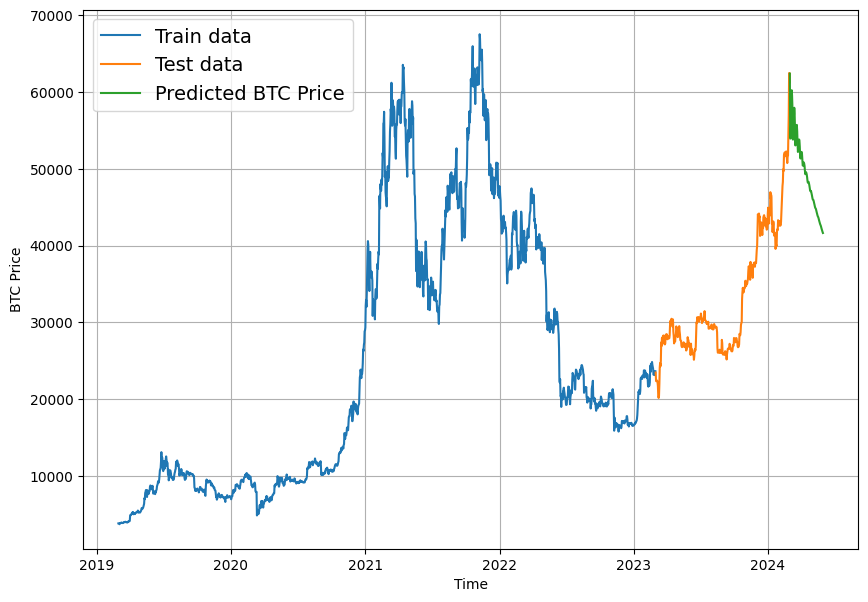

In [64]:
import matplotlib.pyplot as plt

# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train1, values=y_train1, format="-", label="Train data")
plot_time_series(timesteps=X_test1, values=y_test1, format="-", label="Test data")
#plot_time_series(df.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")
